In [1]:
#Skalowanie daje slabe wyniki, bez skalowania jest duzo lepiej
#batch normalization polepszylo znaczaco wyniki
#

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Seed value
# Apparently you may use different seed values at each stage
# seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
# random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
# np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
# tf.compat.v1.set_random_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [3]:
tf.get_logger().setLevel('INFO')
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Generate data

In [4]:
def generate_line(a, b, n=32, noise=0):
    x = np.arange(n)
    return a * x + b + np.random.normal(0, noise, n)

def generate_lines(a, bs, n_train, c, lines, labels):
    for b in bs:
        generated_lines = np.array([generate_line(a, b, noise=0.005) for _ in range(int(n_train/16))])
        generated_labels = np.array([c for _ in range(int(n_train/16))])
        if lines.size == 0:
            lines = generated_lines
            labels = generated_labels
        else:
            lines = np.concatenate((lines, generated_lines))
            labels = np.concatenate((labels, generated_labels))
    return lines, labels
    
def generate_lines_set(n_train):    
    lines = np.array([])
    labels = np.array([])

    lines, labels = generate_lines(0, [0, .4, .8, 1.2, 1.6, 2], n_train, 'g', lines, labels)
    lines, labels = generate_lines(0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'r', lines, labels)
    lines, labels = generate_lines(-0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'b', lines, labels)

    return np.array(lines), np.array(labels)
    

In [5]:
n_lines = 64000
n_types = 16
x_train, y_train = generate_lines_set(64000)

# Scale data

In [6]:
x_train = (x_train - np.amin(x_train)) / (np.amax(x_train) - np.amin(x_train))

# Plot data

4000


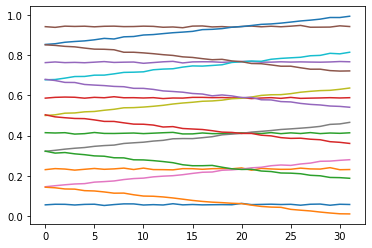

In [7]:
index = 10
interval = int(n_lines / n_types)
print(interval)
while index < n_lines:
    plt.plot(x_train[index])
    index += interval

# Create model

In [8]:
# BATCH SIZE 64,128,256
# LEARNING RATE 0.001, 0.01, 0.005, 0.0005
# STDEV 0.1 0.5 0.05
# EPOCHS 1 5 10 20
# 3 * 4 * 3 * 4 = 144 modele

# batch_sizes = [64, 128, 256]
# learning_rates = [0.0005, 0.001, 0.005, 0.01]
# stdevs = [0.05, 0.1, 0.5]
# epochs = [1, 5, 10, 20]

bs = 64
lr = 0.01
stdev = 0.1
e = 20

original_dim = 32
input_shape = (original_dim, )
intermediate_dim = 16
latent_dim = 8

In [9]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim), stddev=stdev)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# ENCODER
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = BatchNormalization()(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
# encoder.summary()

# DECODER
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = BatchNormalization()(x)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')
# decoder.summary()

# VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
# vae.summary()

# LOSS FUNCTION
reconstruction_loss = MSE(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
optimizer = Adam(lr)
vae.compile(optimizer=optimizer)

In [10]:
# FIT MODEL
hist = vae.fit(x_train,
               verbose=1,
               epochs=e,
               batch_size=bs)

Epoch 1/20
1000/1000 [==============================] - 1s 974us/step - loss: 0.3060
Epoch 2/20
1000/1000 [==============================] - 1s 952us/step - loss: 0.2618
Epoch 3/20
1000/1000 [==============================] - 1s 935us/step - loss: 0.2601
Epoch 4/20
1000/1000 [==============================] - 1s 925us/step - loss: 0.2595
Epoch 5/20
1000/1000 [==============================] - 1s 932us/step - loss: 0.2594
Epoch 6/20
1000/1000 [==============================] - 1s 867us/step - loss: 0.2631
Epoch 7/20
1000/1000 [==============================] - 1s 855us/step - loss: 0.2594
Epoch 8/20
1000/1000 [==============================] - 1s 849us/step - loss: 0.2592
Epoch 9/20
1000/1000 [==============================] - 1s 852us/step - loss: 0.2587
Epoch 10/20
1000/1000 [==============================] - 1s 854us/step - loss: 0.2557
Epoch 11/20
1000/1000 [==============================] - 1s 915us/step - loss: 0.2569
Epoch 12/20
1000/1000 [==============================] - 1s 877

In [259]:
# vae.save("vae", 'tf')
encoder.save_weights("encoder/")
# decoder.save("decoder", 'tf')

DB: 4.14, CH: 3623.46, LOSS: 0.31
DB: 4.14, CH: 3623.48, LOSS: 0.31


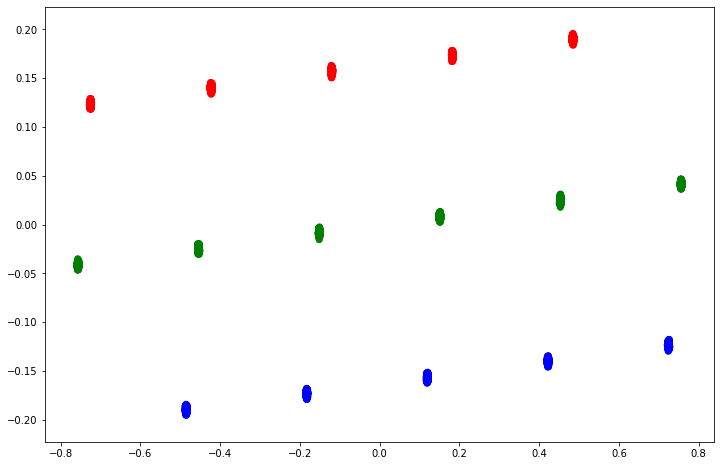

In [11]:
# EVALUATE MODEL
z_mean, _, _ = encoder.predict(x_train, batch_size=bs)
db_score = round(davies_bouldin_score(z_mean, y_train), 2)
ch_score = round(calinski_harabasz_score(z_mean, y_train), 2)
loss = round(hist.history['loss'][0], 2)
z_mean = PCA(n_components=2).fit_transform(z_mean)
print(f"DB: {db_score}, CH: {ch_score}, LOSS: {loss}")
db_score = round(davies_bouldin_score(z_mean, y_train), 2)
ch_score = round(calinski_harabasz_score(z_mean, y_train), 2)
print(f"DB: {db_score}, CH: {ch_score}, LOSS: {loss}")

# SAVE MODEL AND RESULTS
# directory = "LINE_DETECTOR_VAE_MLP_RESULTS/" + f"LOSS{loss}_DBS{db_score}_CHS{ch_score}_LATENT{latent_dim}_STDEV{stdev}_BS{bs}_E{e}_LR{lr}"
# os.mkdir(directory)
# vae.save(f'{directory}/vae.h5', save_format="tf")
plt.figure(figsize=(12,8))
plt.scatter(z_mean[:, 0], z_mean[:, 1],  c=y_train)
# plt.savefig(f"{directory}/LATENT_SPACE.png")
# plt.close('all')

In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [13]:
path = "C:/Studia/Magisterka/Faints-Prediction/"
BP_filename = "BP.csv"
HR_filename = "HR.csv"

train_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/training_set.txt").values.tolist()]
test_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/test_set.txt").values.tolist()]
validation_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/validation_set.txt").values.tolist()]
all_indices = train_indices + test_indices + validation_indices

In [14]:
BP_data = pd.read_csv(path + "DATA/" + BP_filename, low_memory=False)[all_indices]
HR_data = pd.read_csv(path + "DATA/" + HR_filename, low_memory=False)[all_indices]
labels = {col: BP_data[col].iloc[0] for col in BP_data}

BP_max_value = BP_data.iloc[1:].astype(np.float32).max().max()
BP_min_value = BP_data.iloc[1:].astype(np.float32).min().min()
HR_max_value = HR_data.iloc[1:].astype(np.float32).max().max()
HR_min_value = HR_data.iloc[1:].astype(np.float32).min().min()

BP_scaler = MinMaxScaler().fit(np.array([BP_min_value, BP_max_value]).reshape(-1,1))
HR_scaler = MinMaxScaler().fit(np.array([HR_min_value, HR_max_value]).reshape(-1,1))

BP_data_scaled = BP_data.iloc[1:].astype(np.float32).copy()
BP_data_scaled[all_indices] = BP_scaler.transform(BP_data_scaled[all_indices])


HR_data_scaled = HR_data.iloc[1:].astype(np.float32).copy()
HR_data_scaled[all_indices] = HR_scaler.transform(HR_data_scaled[all_indices])

In [251]:
# SMOOTHING
BP_data_scaled_averaged = BP_data_scaled.rolling(1).mean()
HR_data_scaled_averaged = HR_data_scaled.rolling(1).mean()

In [252]:
# 320 bad      375 good
x = np.array(HR_data_scaled_averaged['375'])
x = x[~np.isnan(x)]
x = x[:-(x.shape[0] % 32)]

xs = np.array(np.array_split(x, int(len(x)/32)))
print(xs.shape)
x_test = np.concatenate((x_train, xs[:]))
y_test = np.concatenate((y_train, np.array(['k' for _ in range(len(xs[:]))])))
# y_test = np.concatenate((y_train, np.array(['k' for _ in range(len(xs[:130]))])))
# y_test = np.concatenate((y_test, np.array(['m' for _ in range(len(xs[130:137]))])))
# y_test = np.concatenate((y_test, np.array(['k' for _ in range(len(xs[137:]))])))

(169, 32)


In [253]:
for e in xs[15:19]:
    plt.plot(e)

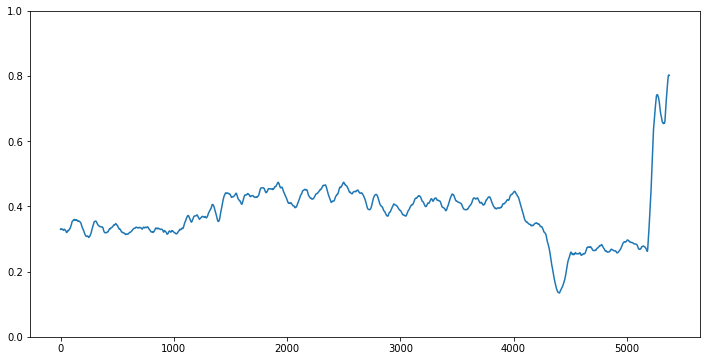

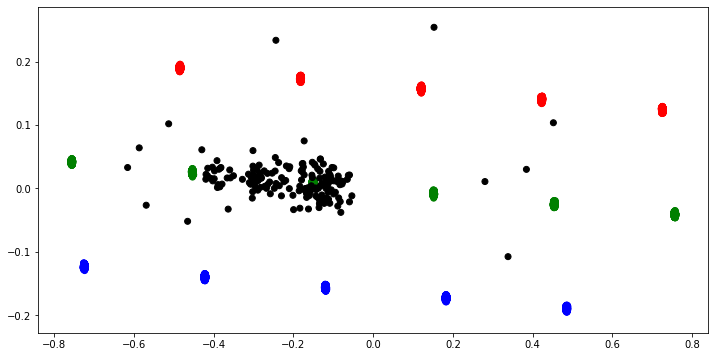

In [130]:
z_mean, _, _ = encoder.predict(x_test, batch_size=bs)
z_mean = PCA(n_components=2).fit_transform(z_mean)

fig = plt.figure(figsize=(12,6))
plt.plot(x)
plt.ylim(0,1)

fig = plt.figure(figsize=(12,6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)

In [131]:
z_test, _, _ = encoder.predict(x_test, batch_size=bs)

In [165]:
greens2 = z_mean[:24000]
greens8 = z_test[:24000]

In [47]:
g2_mean = greens.mean(axis=0)
g8_mean = greens8.mean(axis=0)

In [163]:
principal_axis8 = np.linalg.svd(greens8 - g8_mean)[2][0]

In [166]:
principal_axis2 = np.linalg.svd(greens2 - g2_mean)[2][0]

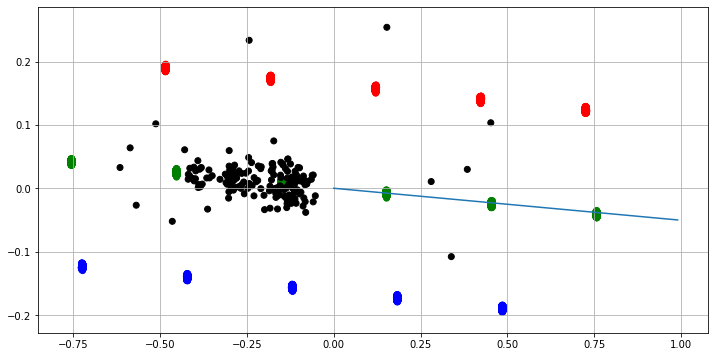

In [133]:
fig = plt.figure(figsize=(12,6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.plot([0,0.99], [0,-0.05])
plt.grid()

In [170]:
principal_axis8

array([ 0.99471396,  0.00296805, -0.02299315,  0.02185841,  0.01666978,
       -0.09036905,  0.03281152,  0.00280067], dtype=float32)

In [188]:
def dist(p, q, rs):
    x = p-q
    return np.linalg.norm(
        np.outer(np.dot(rs-q, x)/np.dot(x, x), x)+q-rs,
        axis=1)

In [190]:
low = z_mean[64138]
med = z_mean[64135]
high = z_mean[64167]
p1 = np.array([0,0], np.float32)
p2 = np.array(principal_axis2, np.float32)

print(dist(p1, p2, np.array([low, med, high])))

[0.03162538 0.07751338 0.1279566 ]


In [261]:
print(np.array([low, med, high]))

[[-5.7365382e-01  2.0713545e-04  6.1163064e-03 -1.7366705e-02
  -2.1483855e-02  6.9799200e-02 -2.7191220e-02  6.5439772e-03]
 [-4.5750871e-01 -1.8681660e-03 -4.1105188e-03 -6.9709420e-03
   1.9999770e-02 -3.9138481e-02  2.1042433e-03  3.6493968e-03]
 [ 4.6503362e-01  5.3686034e-03 -1.1108616e-02 -1.3864636e-03
  -3.8995303e-02  6.2282294e-02 -1.5330935e-02  1.2386577e-02]]


In [191]:
low = z_test[64138]
med = z_test[64135]
high = z_test[64167]
p1 = np.array([0,0,0,0,0,0,0,0], np.float32)
p2 = np.array(principal_axis8, np.float32)

print(dist(p1, p2, np.array([low, med, high])))

[0.0257296  0.08802037 0.11915965]


<IPython.core.display.Javascript object>


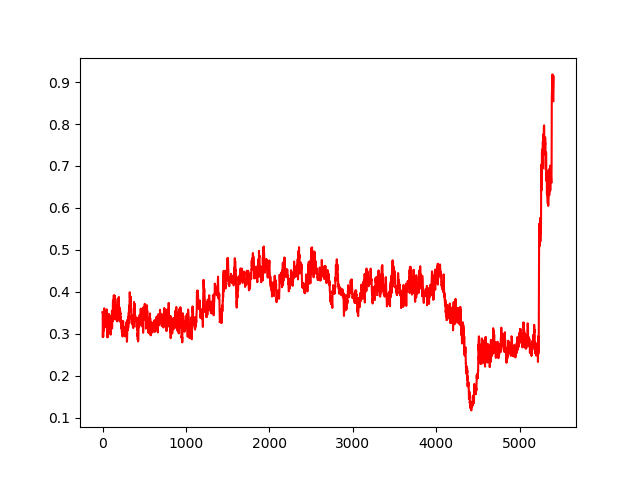

In [254]:
%matplotlib notebook
values = [[1,2], [3,4], [5,4], [3,1], [8,6]]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

t = 0
last_elem = None
for val in xs:
    if last_elem == None:
        ax.plot(range(t, t + len(val)), val, 'r-')
        t += len(val)
    else:
        time_range = range(t-1, t + len(val)) 
        val = np.concatenate(([last_elem], val))
        ax.plot(time_range, val, 'r-')
        t += len(val) - 1
    fig.canvas.draw()
    last_elem = val[-1] 
    time.sleep(0.1)